In [1]:
import IPython
import numpy as np
from ipywidgets import Image
#
from Bio.PDB import PDBParser, PDBIO
#
import openmm
import openmm.app
from openmm.app import PDBFile
from openmm.app import CheckpointReporter
#
from openff.toolkit import ForceField, Molecule, Topology
from openff.units import Quantity, unit
from openff.pablo import CCD_RESIDUE_DEFINITION_CACHE
from openff.pablo import ResidueDefinition
from openff.pablo.chem import PEPTIDE_BOND
from openff.pablo import topology_from_pdb
from openff.interchange import Interchange
from openff.interchange.components._packmol import (
    RHOMBIC_DODECAHEDRON,
    solvate_topology,
)
import sys
sys.path.append('..')
from ptm_prototype import draw_molecule
from ptm_prototype import react_mod
from ptm_prototype import parametrize_with_nagl
#
import rdkit
from rdkit import Chem
from rdkit import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem.rdChemReactions import ReactionFromSmarts
from rdkit.Chem.rdchem import AtomPDBResidueInfo
Chem.SetDefaultPickleProperties(Chem.PropertyPickleOptions.AllProps)
draw_options = Chem.Draw.MolDrawOptions()
draw_options.addAtomIndices = True
print(rdkit.__version__)

2025.03.6


In [2]:
cysteine = CCD_RESIDUE_DEFINITION_CACHE["CYS"][0].to_openff_molecule()
Elironrasib = Molecule.from_smiles("C[C@H](OC)C(N=CC=C1)=[C@@]1[C@](N2CC)=C(CC(C)(C)COC([C@H]3NN(C([C@@H](NC([C@H](C(C)C)N(C(C4(F)CCN(C(C#CC(N(C)C)(C)C)=O)CC4)=O)C)=O)C[C@H]5CN6CCO5)=O)CCC3)=O)C7=C2C=CC6=C7")
Elironrasib.generate_unique_atom_names()
#
covalent_triple_bond_smarts_cis = '[C:10]-[S:1]-[H:2].[C:11]-[C:3]#[C:4]-[C:5](=[O:6])-[N:7](-[C:8])-[C:9]>>[C:10]-[S:1]/[C:3](-[C:11])=[C:4](/[H])[C:5](=[O:6])-[N:7](-[C:8])-[C:9]'
rxn = ReactionFromSmarts(covalent_triple_bond_smarts_cis)
products = list(react_mod([cysteine, Elironrasib], covalent_triple_bond_smarts_cis))
adduct = products[0][0]
adduct.atom(5).name = 'H79x'
#
ligand_resdef = ResidueDefinition.from_molecule(
    molecule=adduct,
    residue_name="LIG",
    linking_bond=PEPTIDE_BOND,
)
#
ser_resdef = CCD_RESIDUE_DEFINITION_CACHE["SER"][6]
sen_resdef = ser_resdef.replace(residue_name='SEN', description='SERINE deprotonated')
#
thr_resdef = CCD_RESIDUE_DEFINITION_CACHE["THR"][6]
thn_resdef = thr_resdef.replace(residue_name='THN', description='THREONINE deprotonated')
#
residue_database_1 = CCD_RESIDUE_DEFINITION_CACHE.with_({"LIG": [ligand_resdef]})
residue_database_2 = residue_database_1.with_({"SEN": [sen_resdef]})
residue_database_3 = residue_database_2.with_({"THN": [thn_resdef]})
#
covalent_topology = topology_from_pdb(
    "cofold/final_covalent_mod.pdb",
    residue_database=residue_database_3,
)
covalent_topology.box_vectors=None
#
force_field = ForceField("openff-2.2.1.offxml", "ff14sb_off_impropers_0.0.4.offxml")
#
charge_handler = force_field.get_parameter_handler('LibraryCharges')
mg_charge_params = {
    "smirks": "[#12+2:1]",
    "charge1": 2.0 * unit.elementary_charge
}
charge_handler.add_parameter(mg_charge_params)
#
vdw_handler = force_field.get_parameter_handler('vdW')
vdw_params = {
    'smirks': '[#12+2:1]',
    'epsilon': 0.07 * unit.kilocalorie_per_mole,
    'sigma': 1.7 * unit.angstrom,
}
vdw_handler.add_parameter(vdw_params)
#
MG = Molecule.from_pdb_and_smiles('cofold/MG.pdb', '[#12+2:1]')
covalent_topology.add_molecule(MG)
#
rdmol = Chem.SDMolSupplier('cofold/GNP_H_charged.sdf')[0]
Chem.SanitizeMol(rdmol)
GNP = Molecule.from_rdkit(rdmol, allow_undefined_stereo=True)
GNP.name = "GNP"
for atom in GNP.atoms:
    atom.metadata['residue_name'] = 'GNP'
covalent_topology.add_molecule(GNP)
#
final_topology = solvate_topology(
    covalent_topology,
    nacl_conc=Quantity(0.1, "mol/L"),
    padding=Quantity(1.0, "nm"),
    box_shape=RHOMBIC_DODECAHEDRON,
)
#
interchange = parametrize_with_nagl(
    force_field=force_field,
    topology=final_topology,
)
interchange.to_pdb('cofold/cofold.pdb')

[18:42:59] mapped atoms in the reactants were not mapped in the products.
  unmapped numbers are: 2 
/home/haolan/anaconda3/envs/openff_ptm_prototype/lib/python3.11/site-packages/openff/amber_ff_ports/amber_ff_ports.py:8: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_filename
/home/haolan/anaconda3/envs/openff_ptm_prototype/lib/python3.11/site-packages/openff/toolkit/utils/base_wrapper.py:67: MoleculeDeprecationWarning: `Molecule.from_pdb_and_smiles` is deprecated in favor of `Topology.from_pdb`, the recommended method for loading PDB files. This method will be removed in a future release of the OpenFF Toolkit.
  value = func(*args, **kwargs)
/home/haolan/anaconda3/envs/openff_ptm_prototype/lib/python3.11/site-packages/openff/toolkit/topology/molecule.py:47

adding dummy charges to force field ...
making Interchange ...
replacing dummy charges with NAGL charges ... 
assigning graph charges to C904H1418FN241O277S5 ...


[18:43:47] WARNING: Proton(s) added/removed



continuing with dummy charge replacement ...
assigning graph charges to GNP ...


[18:43:55] WARNING: Proton(s) added/removed



continuing with dummy charge replacement ...


In [3]:
def swap_pdb_chains(input_pdb_file, output_pdb_file):
    """
    Reads a PDB file and swaps the chain identifiers 'A' and 'B'.
    All other chain identifiers are left unchanged.

    Args:
        input_pdb_file (str): Path to the original PDB file.
        output_pdb_file (str): Path to save the modified PDB file.
    """
    modified_lines = []

    try:
        with open(input_pdb_file, 'r') as infile:
            for line in infile:
                # Standard PDB lines with chain ID: ATOM, HETATM, ANISOU, SIGATM, SIGUIJ, TER
                # We check the record name (first 6 characters)
                record_name = line[:6].strip()

                # Chain ID is at column 22 (index 21 in Python) for these records
                if record_name in ('ATOM', 'HETATM', 'ANISOU', 'SIGATM', 'SIGUIJ', 'TER'):
                    chain_id = line[21] # Get the current chain ID

                    # Determine the new chain ID
                    new_chain_id = chain_id
                    if chain_id == 'C':
                        new_chain_id = 'A'

                    # Construct the new line by splicing
                    # [0:21] is the part before the chain ID
                    # [22:] is the part after the chain ID
                    modified_line = line[:21] + new_chain_id + line[22:]
                    modified_lines.append(modified_line)
                else:
                    # Keep all other lines (HEADER, REMARK, END, etc.) unchanged
                    modified_lines.append(line)

    except FileNotFoundError:
        print(f"Error: File not found at {input_pdb_file}")
        return

    # Write the modified lines to the output file
    with open(output_pdb_file, 'w') as outfile:
        outfile.writelines(modified_lines)

swap_pdb_chains('crystal/final_covalent_mod_1-processed.pdb', 'crystal/final_covalent_mod_1-processed_swapped.pdb')

!pymol sort A and B chains

In [4]:
cysteine = CCD_RESIDUE_DEFINITION_CACHE["CYS"][0].to_openff_molecule()
Elironrasib = Molecule.from_smiles("C[C@H](OC)C(N=CC=C1)=[C@@]1[C@](N2CC)=C(CC(C)(C)COC([C@H]3NN(C([C@@H](NC([C@H](C(C)C)N(C(C4(F)CCN(C(C#CC(N(C)C)(C)C)=O)CC4)=O)C)=O)C[C@H]5CN6CCO5)=O)CCC3)=O)C7=C2C=CC6=C7")
Elironrasib.generate_unique_atom_names()
#
covalent_triple_bond_smarts_cis = '[C:10]-[S:1]-[H:2].[C:11]-[C:3]#[C:4]-[C:5](=[O:6])-[N:7](-[C:8])-[C:9]>>[C:10]-[S:1]/[C:3](-[C:11])=[C:4](/[H])[C:5](=[O:6])-[N:7](-[C:8])-[C:9]'
rxn = ReactionFromSmarts(covalent_triple_bond_smarts_cis)
products = list(react_mod([cysteine, Elironrasib], covalent_triple_bond_smarts_cis))
adduct = products[0][0]
adduct.atom(5).name = 'H79x'
#
ligand_resdef = ResidueDefinition.from_molecule(
    molecule=adduct,
    residue_name="LIG",
    linking_bond=PEPTIDE_BOND,
)
#
ser_resdef = CCD_RESIDUE_DEFINITION_CACHE["SER"][6]
sen_resdef = ser_resdef.replace(residue_name='SEN', description='SERINE deprotonated')
#
thr_resdef = CCD_RESIDUE_DEFINITION_CACHE["THR"][6]
thn_resdef = thr_resdef.replace(residue_name='THN', description='THREONINE deprotonated')
#
residue_database_1 = CCD_RESIDUE_DEFINITION_CACHE.with_({"LIG": [ligand_resdef]})
residue_database_2 = residue_database_1.with_({"SEN": [sen_resdef]})
residue_database_3 = residue_database_2.with_({"THN": [thn_resdef]})
#
covalent_topology = topology_from_pdb(
    "crystal/final_covalent_mod_1-processed_swapped_pymol.pdb",
    residue_database=residue_database_3,
)
covalent_topology.box_vectors=None
#
force_field = ForceField("openff-2.2.1.offxml", "ff14sb_off_impropers_0.0.4.offxml")
#
charge_handler = force_field.get_parameter_handler('LibraryCharges')
mg_charge_params = {
    "smirks": "[#12+2:1]",
    "charge1": 2.0 * unit.elementary_charge
}
charge_handler.add_parameter(mg_charge_params)
#
vdw_handler = force_field.get_parameter_handler('vdW')
vdw_params = {
    'smirks': '[#12+2:1]',
    'epsilon': 0.07 * unit.kilocalorie_per_mole,
    'sigma': 1.7 * unit.angstrom,
}
vdw_handler.add_parameter(vdw_params)
#
MG = Molecule.from_pdb_and_smiles('crystal/MG.pdb', '[#12+2:1]')
covalent_topology.add_molecule(MG)
#
rdmol = Chem.SDMolSupplier('crystal/GNP_H_charged.sdf')[0]
Chem.SanitizeMol(rdmol)
GNP = Molecule.from_rdkit(rdmol, allow_undefined_stereo=True)
GNP.name = "GNP"
for atom in GNP.atoms:
    atom.metadata['residue_name'] = 'GNP'
covalent_topology.add_molecule(GNP)
#
final_topology = solvate_topology(
    covalent_topology,
    nacl_conc=Quantity(0.1, "mol/L"),
    padding=Quantity(1.0, "nm"),
    box_shape=RHOMBIC_DODECAHEDRON,
)
#
interchange_target = parametrize_with_nagl(
    force_field=force_field,
    topology=final_topology,
)
interchange_target.to_pdb('crystal/crystal.pdb')

[18:44:00] mapped atoms in the reactants were not mapped in the products.
  unmapped numbers are: 2 


adding dummy charges to force field ...
making Interchange ...
replacing dummy charges with NAGL charges ... 
assigning graph charges to C904H1418FN241O277S5 ...


[18:44:49] WARNING: Proton(s) added/removed



continuing with dummy charge replacement ...
assigning graph charges to GNP ...


[18:44:57] WARNING: Proton(s) added/removed



continuing with dummy charge replacement ...


In [5]:
import openmm.openmm as openmm
from openmm import app
from openff.units import unit
from openff.units.openmm import to_openmm
import numpy as np
#
system = interchange.to_openmm_system()
topology = interchange.to_openmm_topology()
#
heavy_atom_indices = []
for atom in topology.atoms():
    if (atom.element.symbol != 'H') and (atom.residue.name != ('HOH' or 'NA' or 'CL')):
        heavy_atom_indices.append(atom.index)
particle_indices = heavy_atom_indices
#print(len(particle_indices))
#
system_positions = to_openmm(interchange.positions)
#print(len(system_positions))
target_positions = to_openmm(interchange_target.positions)
#print(len(target_positions))
#
target_positions_restrained = target_positions[particle_indices]
full_reference_positions = list(system_positions)
for i, atom_idx in enumerate(particle_indices):
    full_reference_positions[atom_idx] = target_positions_restrained[i]
full_reference_positions_openmm = openmm.unit.Quantity(
    full_reference_positions, 
    system_positions.unit
)
#print(len(full_reference_positions_openmm))
#
# TMD Parameters
K_TMD = 1000.0 * openmm.unit.md_kilojoule/openmm.unit.mole/openmm.unit.nanometer**2
TARGET_RMSD = 0.0 * openmm.unit.nanometer

# RMSDForce (Collective Variable)
rmsd_cv = openmm.RMSDForce(full_reference_positions_openmm, particle_indices)
rmsd_cv.setName('RMSD_CV')

# CustomCVForce (Harmonic Potential)
energy_expression = f'(0.5 * K_TMD * (r - r_target)^2)'
tmd_force = openmm.CustomCVForce(energy_expression)
tmd_force.setName('TMD_Force')
tmd_force.addCollectiveVariable('r', rmsd_cv)
tmd_force.addGlobalParameter('K_TMD', K_TMD)
tmd_force.addGlobalParameter('r_target', TARGET_RMSD)

#
integrator = openmm.LangevinIntegrator(
    300 * openmm.unit.kelvin,
    1 / openmm.unit.picosecond,
    0.002 * openmm.unit.picoseconds
)
system.addForce(
            openmm.MonteCarloBarostat(
            1*openmm.unit.atmosphere, 
            300*openmm.unit.kelvin,
            ))

# minimisation and unbiased NPT
simulation = app.Simulation(topology, system, integrator)
simulation.context.setPositions(system_positions)
simulation.minimizeEnergy()
state = simulation.context.getState(getPositions=True)
with open('min.pdb', 'w') as output:
    PDBFile.writeFile(topology, state.getPositions(), output)
simulation.context.setVelocitiesToTemperature(300*openmm.unit.kelvin)
simulation.step(500000)
state_eq = simulation.context.getState(getPositions=True)
with open('eq.pdb', 'w') as output_1:
    PDBFile.writeFile(topology, state_eq.getPositions(), output_1)

In [6]:
class BiasReporter:
    """A custom reporter to record the RMSD (r) and the bias potential (E_bias)."""
    def __init__(self, file_name, report_interval, tmd_force_group, tmd_force_index):
        # Using a safer file opening method
        self._out = open(file_name, 'w')
        self._interval = report_interval
        self._force_group = tmd_force_group
        self._cv_idx = tmd_force_index # Index of the CustomCVForce in the System
        self._out.write(f'# Step\tRMSD (nm)\tBiasEnergy (kJ/mol)\n')
        
    def __del__(self):
        # Ensure the file is closed when the object is deleted
        if hasattr(self, '_out') and not self._out.closed:
            self._out.close()

    def describeNextReport(self, simulation):
        steps = self._interval - simulation.currentStep % self._interval
        # We need Energy (True) and we need the state to access the context 
        # for collective variables.
        return (steps, False, False, False, True, False)

    def report(self, simulation, state):
        step = simulation.currentStep
        
        # 1. Get the potential energy of the TMD force group (E_bias)
        # We only request energy for the specific group
        bias_energy = simulation.context.getState(
            getEnergy=True, 
            groups={self._force_group}
        ).getPotentialEnergy()
        
        # 2. Get the RMSD value (r) from the CustomCVForce object
        # FIX: The method name was corrected from getCollectiveVariables to getCustomCollectiveVariables.
        collective_variables = simulation.context.getCustomCollectiveVariables(self._cv_idx)
        rmsd_value = collective_variables[0] 

        # Write data, converting to preferred units
        self._out.write(f'{step}\t'
                        f'{rmsd_value.value_in_unit(unit.nanometer):.6f}\t'
                        f'{bias_energy.value_in_unit(unit.kilojoule/unit.mole):.6f}\n')

In [7]:
equil_state = simulation.context.getState(getPositions=True, getVelocities=True)
#
TMD_FORCE_GROUP = 1
tmd_force.setForceGroup(TMD_FORCE_GROUP)
system.addForce(tmd_force)
all_forces = system.getForces()
tmd_force_name = tmd_force.getName()
tmd_force_index = next(
    (i for i, f in enumerate(all_forces) if f.getName() == tmd_force_name),
    -1
)

In [8]:
steered_integrator = openmm.LangevinIntegrator(
    300 * openmm.unit.kelvin,
    1 / openmm.unit.picosecond,
    0.002 * openmm.unit.picoseconds 
)
#
steered_simulation = app.Simulation(topology, system, steered_integrator)
steered_simulation.context.setState(equil_state)
#
steered_simulation.reporters.append(app.DCDReporter('smd_forward.dcd', 1000))
steered_simulation.reporters.append(app.StateDataReporter('smd_forward.csv', 1000, 
    step=True, potentialEnergy=True, kineticEnergy=True, 
    temperature=True, totalEnergy=True, volume=True, density=True, speed=True))
steered_simulation.reporters.append(BiasReporter('tmd_bias_work.dat', 1000, TMD_FORCE_GROUP, tmd_force_index))
#
print(f"Starting TMD forward simulation with K_TMD={K_TMD}...")
steered_simulation.step(1000000)

Starting TMD forward simulation with K_TMD=1000.0 kJ/(nm**2 mol)...


AttributeError: 'Context' object has no attribute 'getCustomCollectiveVariables'

dcdplugin) detected standard 32-bit DCD file of native endianness
dcdplugin) CHARMM format DCD file (also NAMD 2.1 and later)


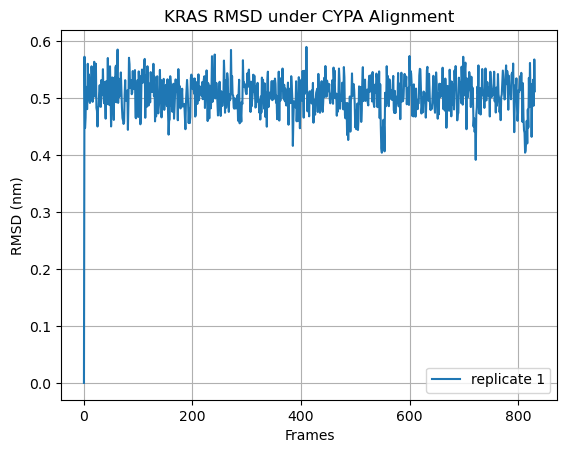

In [ ]:
import numpy as np
import mdtraj as md
import seaborn as sns
from matplotlib import pyplot as plt

def plot_rmsd_fluctuations_multiple(traj_files, top_file, plot_type, window, image_molecules=False):
    rmsd_arrays = []
    labels = []
    for i, traj_file in enumerate(traj_files):
        traj = md.load(traj_file, top=top_file)
        if image_molecules:
            traj.image_molecules(inplace=True)
        CYPA_atoms = traj.topology.select('protein and chainid 0 and name CA')
        KRAS_atoms = traj.topology.select('protein and chainid 1 and name CA')
        traj.superpose(traj, frame=0, atom_indices=CYPA_atoms)
        traj.save_xtc('smd_forward_processed.xtc')
        #
        result = traj.xyz[:, KRAS_atoms, :] - traj.xyz[0, KRAS_atoms, :]
        ligand_rmsd = np.sqrt((result ** 2).sum(axis=-1).mean(axis=-1))
        n_windows = len(ligand_rmsd) // window
        avg_rmsd = np.array([ligand_rmsd[i*window:(i+1)*window].mean() for i in range(n_windows)])
        avg_frames = np.arange(n_windows) * window
        rmsd_arrays.append(avg_rmsd)
        labels.append(f'replicate {i+1}')
        if plot_type == 'line':
            plt.plot(avg_frames, avg_rmsd, label=labels[-1])
            plt.xlabel('Frames')
            plt.ylabel('RMSD (nm)')
            plt.title(f'KRAS RMSD under CYPA Alignment')
        elif plot_type == 'hist':
            sns.kdeplot(avg_rmsd, label=labels[-1])
            plt.xlabel('RMSD (nm)')
            plt.title('KRAS RMSD Distribution under CYPA Alignment')
    plt.grid(True)
    plt.legend()
    plt.show()
    plt.close()
    return rmsd_arrays

forward_sim_rmsd = plot_rmsd_fluctuations_multiple(['smd_forward.dcd'], 'min.pdb', 'line', 1, image_molecules=True)